In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment
from BackGround_modules.Class_4_Create_Sample_Classification_instancs import Make_Sample_Classification

##### Define_Basic_Parameters

In [5]:
# define the year_name for test, here choose these years because they represent
# Landsat8/7/5 sensors respectively
year_name = ['2017_2019','2011_2013', '2008_2010']
percent_value = [1,2,3,5,7,10,20,30,50,70,100]
tree_num = [1] + list(range(10,121,10))

combination_name = ['Landsat',
                    'Fourier',
                    'Landsat_Fourier',
                    'Landsat_Mean',
                    'Fourier_Mean',
                    'Landsat_Fourier_Mean',
                    'Landsat_Fourier_Mean_Climate',
                    'Landsat_Fourier_Mean_Terrain',
                    'Landsat_Fourier_Mean_Terrain_Climate']

#### Calculate the band_combination accuracy using [Invariant_traning_sample] with different percentage reduction

Produce classification_instances

In [6]:
# define the path to point_with_img_value 
path = 'users/wangjinzhulala/North_China_Plain_Python/Sample_extract_img'

# instantiate the combo_instance dictionary
Combo_instance_with_village = {}

# Create sample_classification instances through [year] --> [Percent] --> [band_combination] --> [Tree]
for year in year_name:
    
    Invarient_sample = ee.FeatureCollection(f'{path}/Control_sample_ext_img_{year}')
    
    # import samples
    Invarient_built      = Invarient_sample.filterMetadata('Built','equals',1)
    Invarient_non_Built  = Invarient_sample.filterMetadata('Built','equals',0)
       
    for pct in percent_value:
        
        # Create percentage_reduced samples, only use non-built points from verified points
        Subset_Invarient_built     = Make_Sample_Classification.Step_1_Subset_sample(Invarient_built,pct)
        Subset_Invarient_non_Built = Make_Sample_Classification.Step_1_Subset_sample(Invarient_non_Built,pct)
        
        # Merge the built and non-built points that been percentage reduced
        Sample_merge = Subset_Invarient_built.merge(Subset_Invarient_non_Built)
        
        # Get the band_combo names
        Band_combo   = Make_Sample_Classification.Step_2_Create_Band_Combo(Sample_merge)
        
        for combo in Band_combo:
            Accuracy_instance = Make_Sample_Classification.\
                                Step_3_Create_Classification_Instance(year,Sample_merge,
                                                                      combo,tree_num,
                                                                      pct,classificaiton_func = Classification ) 
            Combo_instance_with_village.update(Accuracy_instance)
        

Percetage coresponded size is 39
Percetage coresponded size is 39
Classification of 2017_2019_Landsat_pct_001_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_001_tree_0001 completed!
Classification of 2017_2

Percetage coresponded size is 79
Percetage coresponded size is 79
Classification of 2017_2019_Landsat_pct_002_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_002_tree_0001 completed!
Classification of 2017_2

Percetage coresponded size is 119
Percetage coresponded size is 119
Classification of 2017_2019_Landsat_pct_003_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_003_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 199
Percetage coresponded size is 199
Classification of 2017_2019_Landsat_pct_005_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_005_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 279
Percetage coresponded size is 279
Classification of 2017_2019_Landsat_pct_007_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_007_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 399
Percetage coresponded size is 398
Classification of 2017_2019_Landsat_pct_010_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_010_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 799
Percetage coresponded size is 797
Classification of 2017_2019_Landsat_pct_020_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_020_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 1199
Percetage coresponded size is 1196
Classification of 2017_2019_Landsat_pct_030_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_030_tree_0001 completed!
Classification of 20

Percetage coresponded size is 1999
Percetage coresponded size is 1993
Classification of 2017_2019_Landsat_pct_050_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_050_tree_0001 completed!
Classification of 20

Percetage coresponded size is 2798
Percetage coresponded size is 2790
Classification of 2017_2019_Landsat_pct_070_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_070_tree_0001 completed!
Classification of 20

Percetage coresponded size is 3998
Percetage coresponded size is 3987
Classification of 2017_2019_Landsat_pct_100_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_100_tree_0001 completed!
Classification of 20

Percetage coresponded size is 39
Percetage coresponded size is 39
Classification of 2011_2013_Landsat_pct_001_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_001_tree_0001 completed!
Classification of 2011_2

Percetage coresponded size is 79
Percetage coresponded size is 79
Classification of 2011_2013_Landsat_pct_002_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_002_tree_0001 completed!
Classification of 2011_2

Percetage coresponded size is 119
Percetage coresponded size is 119
Classification of 2011_2013_Landsat_pct_003_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_003_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 199
Percetage coresponded size is 199
Classification of 2011_2013_Landsat_pct_005_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_005_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 279
Percetage coresponded size is 279
Classification of 2011_2013_Landsat_pct_007_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_007_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 399
Percetage coresponded size is 398
Classification of 2011_2013_Landsat_pct_010_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_010_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 799
Percetage coresponded size is 797
Classification of 2011_2013_Landsat_pct_020_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_020_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 1199
Percetage coresponded size is 1196
Classification of 2011_2013_Landsat_pct_030_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_030_tree_0001 completed!
Classification of 20

Percetage coresponded size is 1999
Percetage coresponded size is 1993
Classification of 2011_2013_Landsat_pct_050_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_050_tree_0001 completed!
Classification of 20

Percetage coresponded size is 2798
Percetage coresponded size is 2790
Classification of 2011_2013_Landsat_pct_070_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_070_tree_0001 completed!
Classification of 20

Percetage coresponded size is 3998
Percetage coresponded size is 3987
Classification of 2011_2013_Landsat_pct_100_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_100_tree_0001 completed!
Classification of 20

Percetage coresponded size is 39
Percetage coresponded size is 39
Classification of 2008_2010_Landsat_pct_001_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_001_tree_0001 completed!
Classification of 2008_2

Percetage coresponded size is 79
Percetage coresponded size is 79
Classification of 2008_2010_Landsat_pct_002_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_002_tree_0001 completed!
Classification of 2008_2

Percetage coresponded size is 119
Percetage coresponded size is 119
Classification of 2008_2010_Landsat_pct_003_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_003_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 199
Percetage coresponded size is 199
Classification of 2008_2010_Landsat_pct_005_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_005_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 279
Percetage coresponded size is 279
Classification of 2008_2010_Landsat_pct_007_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_007_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 399
Percetage coresponded size is 398
Classification of 2008_2010_Landsat_pct_010_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_010_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 799
Percetage coresponded size is 797
Classification of 2008_2010_Landsat_pct_020_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_020_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 1199
Percetage coresponded size is 1196
Classification of 2008_2010_Landsat_pct_030_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_030_tree_0001 completed!
Classification of 20

Percetage coresponded size is 1999
Percetage coresponded size is 1993
Classification of 2008_2010_Landsat_pct_050_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_050_tree_0001 completed!
Classification of 20

Percetage coresponded size is 2798
Percetage coresponded size is 2790
Classification of 2008_2010_Landsat_pct_070_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_070_tree_0001 completed!
Classification of 20

Percetage coresponded size is 3998
Percetage coresponded size is 3987
Classification of 2008_2010_Landsat_pct_100_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_100_tree_0001 completed!
Classification of 20

Conduct the computation in GEE using above instances

In [7]:
# innitialize the accuracy dict
Combo_acc_with_village = {}

# innitilize operation flag to report the process
Opts_flag  = 0
Opts_tatal = len(year_name) * len(combination_name) * len(percent_value) * len(tree_num)

# unpack the combo_instance through [year] --> [band_combination] --> [Percent] --> [Tree]
for year in year_name:
    for name in combination_name:
        for pct in percent_value:
            for tree in tree_num:

                Opts_flag+=1

                Combo_acc_with_village[(year,name,pct,tree)] = Accuracy_assesment(Combo_instance_with_village[(year,name,pct,tree)])\
                                              .Stp_1_Calculate_Accuracy()
                # print out the process
                print(f'{year}_{name}_pct_{pct:03}_tree_{tree:03} accuracy computation finished! ==>{Opts_flag:04}/{Opts_tatal}')
            print('_________________')

2017_2019_Landsat_pct_001_tree_001 accuracy computation finished! ==>0001/3861
2017_2019_Landsat_pct_001_tree_010 accuracy computation finished! ==>0002/3861
2017_2019_Landsat_pct_001_tree_020 accuracy computation finished! ==>0003/3861
2017_2019_Landsat_pct_001_tree_030 accuracy computation finished! ==>0004/3861
2017_2019_Landsat_pct_001_tree_040 accuracy computation finished! ==>0005/3861
2017_2019_Landsat_pct_001_tree_050 accuracy computation finished! ==>0006/3861
2017_2019_Landsat_pct_001_tree_060 accuracy computation finished! ==>0007/3861
2017_2019_Landsat_pct_001_tree_070 accuracy computation finished! ==>0008/3861
2017_2019_Landsat_pct_001_tree_080 accuracy computation finished! ==>0009/3861
2017_2019_Landsat_pct_001_tree_090 accuracy computation finished! ==>0010/3861
2017_2019_Landsat_pct_001_tree_100 accuracy computation finished! ==>0011/3861
2017_2019_Landsat_pct_001_tree_110 accuracy computation finished! ==>0012/3861
2017_2019_Landsat_pct_001_tree_120 accuracy computat

2017_2019_Landsat_pct_030_tree_120 accuracy computation finished! ==>0104/3861
_________________
2017_2019_Landsat_pct_050_tree_001 accuracy computation finished! ==>0105/3861
2017_2019_Landsat_pct_050_tree_010 accuracy computation finished! ==>0106/3861
2017_2019_Landsat_pct_050_tree_020 accuracy computation finished! ==>0107/3861
2017_2019_Landsat_pct_050_tree_030 accuracy computation finished! ==>0108/3861
2017_2019_Landsat_pct_050_tree_040 accuracy computation finished! ==>0109/3861
2017_2019_Landsat_pct_050_tree_050 accuracy computation finished! ==>0110/3861
2017_2019_Landsat_pct_050_tree_060 accuracy computation finished! ==>0111/3861
2017_2019_Landsat_pct_050_tree_070 accuracy computation finished! ==>0112/3861
2017_2019_Landsat_pct_050_tree_080 accuracy computation finished! ==>0113/3861
2017_2019_Landsat_pct_050_tree_090 accuracy computation finished! ==>0114/3861
2017_2019_Landsat_pct_050_tree_100 accuracy computation finished! ==>0115/3861
2017_2019_Landsat_pct_050_tree_110

2017_2019_Fourier_pct_007_tree_100 accuracy computation finished! ==>0206/3861
2017_2019_Fourier_pct_007_tree_110 accuracy computation finished! ==>0207/3861
2017_2019_Fourier_pct_007_tree_120 accuracy computation finished! ==>0208/3861
_________________
2017_2019_Fourier_pct_010_tree_001 accuracy computation finished! ==>0209/3861
2017_2019_Fourier_pct_010_tree_010 accuracy computation finished! ==>0210/3861
2017_2019_Fourier_pct_010_tree_020 accuracy computation finished! ==>0211/3861
2017_2019_Fourier_pct_010_tree_030 accuracy computation finished! ==>0212/3861
2017_2019_Fourier_pct_010_tree_040 accuracy computation finished! ==>0213/3861
2017_2019_Fourier_pct_010_tree_050 accuracy computation finished! ==>0214/3861
2017_2019_Fourier_pct_010_tree_060 accuracy computation finished! ==>0215/3861
2017_2019_Fourier_pct_010_tree_070 accuracy computation finished! ==>0216/3861
2017_2019_Fourier_pct_010_tree_080 accuracy computation finished! ==>0217/3861
2017_2019_Fourier_pct_010_tree_090

2017_2019_Landsat_Fourier_pct_002_tree_060 accuracy computation finished! ==>0306/3861
2017_2019_Landsat_Fourier_pct_002_tree_070 accuracy computation finished! ==>0307/3861
2017_2019_Landsat_Fourier_pct_002_tree_080 accuracy computation finished! ==>0308/3861
2017_2019_Landsat_Fourier_pct_002_tree_090 accuracy computation finished! ==>0309/3861
2017_2019_Landsat_Fourier_pct_002_tree_100 accuracy computation finished! ==>0310/3861
2017_2019_Landsat_Fourier_pct_002_tree_110 accuracy computation finished! ==>0311/3861
2017_2019_Landsat_Fourier_pct_002_tree_120 accuracy computation finished! ==>0312/3861
_________________
2017_2019_Landsat_Fourier_pct_003_tree_001 accuracy computation finished! ==>0313/3861
2017_2019_Landsat_Fourier_pct_003_tree_010 accuracy computation finished! ==>0314/3861
2017_2019_Landsat_Fourier_pct_003_tree_020 accuracy computation finished! ==>0315/3861
2017_2019_Landsat_Fourier_pct_003_tree_030 accuracy computation finished! ==>0316/3861
2017_2019_Landsat_Fourier

2017_2019_Landsat_Fourier_pct_050_tree_080 accuracy computation finished! ==>0399/3861
2017_2019_Landsat_Fourier_pct_050_tree_090 accuracy computation finished! ==>0400/3861
2017_2019_Landsat_Fourier_pct_050_tree_100 accuracy computation finished! ==>0401/3861
2017_2019_Landsat_Fourier_pct_050_tree_110 accuracy computation finished! ==>0402/3861
2017_2019_Landsat_Fourier_pct_050_tree_120 accuracy computation finished! ==>0403/3861
_________________
2017_2019_Landsat_Fourier_pct_070_tree_001 accuracy computation finished! ==>0404/3861
2017_2019_Landsat_Fourier_pct_070_tree_010 accuracy computation finished! ==>0405/3861
2017_2019_Landsat_Fourier_pct_070_tree_020 accuracy computation finished! ==>0406/3861
2017_2019_Landsat_Fourier_pct_070_tree_030 accuracy computation finished! ==>0407/3861
2017_2019_Landsat_Fourier_pct_070_tree_040 accuracy computation finished! ==>0408/3861
2017_2019_Landsat_Fourier_pct_070_tree_050 accuracy computation finished! ==>0409/3861
2017_2019_Landsat_Fourier

2017_2019_Landsat_Mean_pct_007_tree_120 accuracy computation finished! ==>0494/3861
_________________
2017_2019_Landsat_Mean_pct_010_tree_001 accuracy computation finished! ==>0495/3861
2017_2019_Landsat_Mean_pct_010_tree_010 accuracy computation finished! ==>0496/3861
2017_2019_Landsat_Mean_pct_010_tree_020 accuracy computation finished! ==>0497/3861
2017_2019_Landsat_Mean_pct_010_tree_030 accuracy computation finished! ==>0498/3861
2017_2019_Landsat_Mean_pct_010_tree_040 accuracy computation finished! ==>0499/3861
2017_2019_Landsat_Mean_pct_010_tree_050 accuracy computation finished! ==>0500/3861
2017_2019_Landsat_Mean_pct_010_tree_060 accuracy computation finished! ==>0501/3861
2017_2019_Landsat_Mean_pct_010_tree_070 accuracy computation finished! ==>0502/3861
2017_2019_Landsat_Mean_pct_010_tree_080 accuracy computation finished! ==>0503/3861
2017_2019_Landsat_Mean_pct_010_tree_090 accuracy computation finished! ==>0504/3861
2017_2019_Landsat_Mean_pct_010_tree_100 accuracy computati

2017_2019_Fourier_Mean_pct_002_tree_040 accuracy computation finished! ==>0590/3861
2017_2019_Fourier_Mean_pct_002_tree_050 accuracy computation finished! ==>0591/3861
2017_2019_Fourier_Mean_pct_002_tree_060 accuracy computation finished! ==>0592/3861
2017_2019_Fourier_Mean_pct_002_tree_070 accuracy computation finished! ==>0593/3861
2017_2019_Fourier_Mean_pct_002_tree_080 accuracy computation finished! ==>0594/3861
2017_2019_Fourier_Mean_pct_002_tree_090 accuracy computation finished! ==>0595/3861
2017_2019_Fourier_Mean_pct_002_tree_100 accuracy computation finished! ==>0596/3861
2017_2019_Fourier_Mean_pct_002_tree_110 accuracy computation finished! ==>0597/3861
2017_2019_Fourier_Mean_pct_002_tree_120 accuracy computation finished! ==>0598/3861
_________________
2017_2019_Fourier_Mean_pct_003_tree_001 accuracy computation finished! ==>0599/3861
2017_2019_Fourier_Mean_pct_003_tree_010 accuracy computation finished! ==>0600/3861
2017_2019_Fourier_Mean_pct_003_tree_020 accuracy computati

2017_2019_Fourier_Mean_pct_050_tree_100 accuracy computation finished! ==>0687/3861
2017_2019_Fourier_Mean_pct_050_tree_110 accuracy computation finished! ==>0688/3861
2017_2019_Fourier_Mean_pct_050_tree_120 accuracy computation finished! ==>0689/3861
_________________
2017_2019_Fourier_Mean_pct_070_tree_001 accuracy computation finished! ==>0690/3861
2017_2019_Fourier_Mean_pct_070_tree_010 accuracy computation finished! ==>0691/3861
2017_2019_Fourier_Mean_pct_070_tree_020 accuracy computation finished! ==>0692/3861
2017_2019_Fourier_Mean_pct_070_tree_030 accuracy computation finished! ==>0693/3861
2017_2019_Fourier_Mean_pct_070_tree_040 accuracy computation finished! ==>0694/3861
2017_2019_Fourier_Mean_pct_070_tree_050 accuracy computation finished! ==>0695/3861
2017_2019_Fourier_Mean_pct_070_tree_060 accuracy computation finished! ==>0696/3861
2017_2019_Fourier_Mean_pct_070_tree_070 accuracy computation finished! ==>0697/3861
2017_2019_Fourier_Mean_pct_070_tree_080 accuracy computati

2017_2019_Landsat_Fourier_Mean_pct_007_tree_100 accuracy computation finished! ==>0778/3861
2017_2019_Landsat_Fourier_Mean_pct_007_tree_110 accuracy computation finished! ==>0779/3861
2017_2019_Landsat_Fourier_Mean_pct_007_tree_120 accuracy computation finished! ==>0780/3861
_________________
2017_2019_Landsat_Fourier_Mean_pct_010_tree_001 accuracy computation finished! ==>0781/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_010 accuracy computation finished! ==>0782/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_020 accuracy computation finished! ==>0783/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_030 accuracy computation finished! ==>0784/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_040 accuracy computation finished! ==>0785/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_050 accuracy computation finished! ==>0786/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_060 accuracy computation finished! ==>0787/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_070 accuracy compu

2017_2019_Landsat_Fourier_Mean_Climate_pct_001_tree_070 accuracy computation finished! ==>0866/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_001_tree_080 accuracy computation finished! ==>0867/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_001_tree_090 accuracy computation finished! ==>0868/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_001_tree_100 accuracy computation finished! ==>0869/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_001_tree_110 accuracy computation finished! ==>0870/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_001_tree_120 accuracy computation finished! ==>0871/3861
_________________
2017_2019_Landsat_Fourier_Mean_Climate_pct_002_tree_001 accuracy computation finished! ==>0872/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_002_tree_010 accuracy computation finished! ==>0873/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_002_tree_020 accuracy computation finished! ==>0874/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_002_tree_030 accuracy computation finis

2017_2019_Landsat_Fourier_Mean_Climate_pct_020_tree_100 accuracy computation finished! ==>0947/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_020_tree_110 accuracy computation finished! ==>0948/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_020_tree_120 accuracy computation finished! ==>0949/3861
_________________
2017_2019_Landsat_Fourier_Mean_Climate_pct_030_tree_001 accuracy computation finished! ==>0950/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_030_tree_010 accuracy computation finished! ==>0951/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_030_tree_020 accuracy computation finished! ==>0952/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_030_tree_030 accuracy computation finished! ==>0953/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_030_tree_040 accuracy computation finished! ==>0954/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_030_tree_050 accuracy computation finished! ==>0955/3861
2017_2019_Landsat_Fourier_Mean_Climate_pct_030_tree_060 accuracy computation finis

2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_001 accuracy computation finished! ==>1028/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_010 accuracy computation finished! ==>1029/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_020 accuracy computation finished! ==>1030/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_030 accuracy computation finished! ==>1031/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_040 accuracy computation finished! ==>1032/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_050 accuracy computation finished! ==>1033/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_060 accuracy computation finished! ==>1034/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_070 accuracy computation finished! ==>1035/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_080 accuracy computation finished! ==>1036/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_003_tree_090 accuracy computation finished! ==>1037/3861


2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_030 accuracy computation finished! ==>1109/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_040 accuracy computation finished! ==>1110/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_050 accuracy computation finished! ==>1111/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_060 accuracy computation finished! ==>1112/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_070 accuracy computation finished! ==>1113/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_080 accuracy computation finished! ==>1114/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_090 accuracy computation finished! ==>1115/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_100 accuracy computation finished! ==>1116/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_110 accuracy computation finished! ==>1117/3861
2017_2019_Landsat_Fourier_Mean_Terrain_pct_050_tree_120 accuracy computation finished! ==>1118/3861


2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_005_tree_030 accuracy computation finished! ==>1187/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_005_tree_040 accuracy computation finished! ==>1188/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_005_tree_050 accuracy computation finished! ==>1189/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_005_tree_060 accuracy computation finished! ==>1190/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_005_tree_070 accuracy computation finished! ==>1191/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_005_tree_080 accuracy computation finished! ==>1192/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_005_tree_090 accuracy computation finished! ==>1193/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_005_tree_100 accuracy computation finished! ==>1194/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_005_tree_110 accuracy computation finished! ==>1195/3861
2017_2019_Landsat_Fourier_Me

2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_070_tree_001 accuracy computation finished! ==>1262/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_070_tree_010 accuracy computation finished! ==>1263/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_070_tree_020 accuracy computation finished! ==>1264/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_070_tree_030 accuracy computation finished! ==>1265/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_070_tree_040 accuracy computation finished! ==>1266/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_070_tree_050 accuracy computation finished! ==>1267/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_070_tree_060 accuracy computation finished! ==>1268/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_070_tree_070 accuracy computation finished! ==>1269/3861
2017_2019_Landsat_Fourier_Mean_Terrain_Climate_pct_070_tree_080 accuracy computation finished! ==>1270/3861
2017_2019_Landsat_Fourier_Me

2011_2013_Landsat_pct_010_tree_020 accuracy computation finished! ==>1355/3861
2011_2013_Landsat_pct_010_tree_030 accuracy computation finished! ==>1356/3861
2011_2013_Landsat_pct_010_tree_040 accuracy computation finished! ==>1357/3861
2011_2013_Landsat_pct_010_tree_050 accuracy computation finished! ==>1358/3861
2011_2013_Landsat_pct_010_tree_060 accuracy computation finished! ==>1359/3861
2011_2013_Landsat_pct_010_tree_070 accuracy computation finished! ==>1360/3861
2011_2013_Landsat_pct_010_tree_080 accuracy computation finished! ==>1361/3861
2011_2013_Landsat_pct_010_tree_090 accuracy computation finished! ==>1362/3861
2011_2013_Landsat_pct_010_tree_100 accuracy computation finished! ==>1363/3861
2011_2013_Landsat_pct_010_tree_110 accuracy computation finished! ==>1364/3861
2011_2013_Landsat_pct_010_tree_120 accuracy computation finished! ==>1365/3861
_________________
2011_2013_Landsat_pct_020_tree_001 accuracy computation finished! ==>1366/3861
2011_2013_Landsat_pct_020_tree_010

2011_2013_Fourier_pct_003_tree_001 accuracy computation finished! ==>1457/3861
2011_2013_Fourier_pct_003_tree_010 accuracy computation finished! ==>1458/3861
2011_2013_Fourier_pct_003_tree_020 accuracy computation finished! ==>1459/3861
2011_2013_Fourier_pct_003_tree_030 accuracy computation finished! ==>1460/3861
2011_2013_Fourier_pct_003_tree_040 accuracy computation finished! ==>1461/3861
2011_2013_Fourier_pct_003_tree_050 accuracy computation finished! ==>1462/3861
2011_2013_Fourier_pct_003_tree_060 accuracy computation finished! ==>1463/3861
2011_2013_Fourier_pct_003_tree_070 accuracy computation finished! ==>1464/3861
2011_2013_Fourier_pct_003_tree_080 accuracy computation finished! ==>1465/3861
2011_2013_Fourier_pct_003_tree_090 accuracy computation finished! ==>1466/3861
2011_2013_Fourier_pct_003_tree_100 accuracy computation finished! ==>1467/3861
2011_2013_Fourier_pct_003_tree_110 accuracy computation finished! ==>1468/3861
2011_2013_Fourier_pct_003_tree_120 accuracy computat

2011_2013_Fourier_pct_070_tree_120 accuracy computation finished! ==>1560/3861
_________________
2011_2013_Fourier_pct_100_tree_001 accuracy computation finished! ==>1561/3861
2011_2013_Fourier_pct_100_tree_010 accuracy computation finished! ==>1562/3861
2011_2013_Fourier_pct_100_tree_020 accuracy computation finished! ==>1563/3861
2011_2013_Fourier_pct_100_tree_030 accuracy computation finished! ==>1564/3861
2011_2013_Fourier_pct_100_tree_040 accuracy computation finished! ==>1565/3861
2011_2013_Fourier_pct_100_tree_050 accuracy computation finished! ==>1566/3861
2011_2013_Fourier_pct_100_tree_060 accuracy computation finished! ==>1567/3861
2011_2013_Fourier_pct_100_tree_070 accuracy computation finished! ==>1568/3861
2011_2013_Fourier_pct_100_tree_080 accuracy computation finished! ==>1569/3861
2011_2013_Fourier_pct_100_tree_090 accuracy computation finished! ==>1570/3861
2011_2013_Fourier_pct_100_tree_100 accuracy computation finished! ==>1571/3861
2011_2013_Fourier_pct_100_tree_110

2011_2013_Landsat_Fourier_pct_020_tree_020 accuracy computation finished! ==>1654/3861
2011_2013_Landsat_Fourier_pct_020_tree_030 accuracy computation finished! ==>1655/3861
2011_2013_Landsat_Fourier_pct_020_tree_040 accuracy computation finished! ==>1656/3861
2011_2013_Landsat_Fourier_pct_020_tree_050 accuracy computation finished! ==>1657/3861
2011_2013_Landsat_Fourier_pct_020_tree_060 accuracy computation finished! ==>1658/3861
2011_2013_Landsat_Fourier_pct_020_tree_070 accuracy computation finished! ==>1659/3861
2011_2013_Landsat_Fourier_pct_020_tree_080 accuracy computation finished! ==>1660/3861
2011_2013_Landsat_Fourier_pct_020_tree_090 accuracy computation finished! ==>1661/3861
2011_2013_Landsat_Fourier_pct_020_tree_100 accuracy computation finished! ==>1662/3861
2011_2013_Landsat_Fourier_pct_020_tree_110 accuracy computation finished! ==>1663/3861
2011_2013_Landsat_Fourier_pct_020_tree_120 accuracy computation finished! ==>1664/3861
_________________
2011_2013_Landsat_Fourier

2011_2013_Landsat_Mean_pct_003_tree_050 accuracy computation finished! ==>1748/3861
2011_2013_Landsat_Mean_pct_003_tree_060 accuracy computation finished! ==>1749/3861
2011_2013_Landsat_Mean_pct_003_tree_070 accuracy computation finished! ==>1750/3861
2011_2013_Landsat_Mean_pct_003_tree_080 accuracy computation finished! ==>1751/3861
2011_2013_Landsat_Mean_pct_003_tree_090 accuracy computation finished! ==>1752/3861
2011_2013_Landsat_Mean_pct_003_tree_100 accuracy computation finished! ==>1753/3861
2011_2013_Landsat_Mean_pct_003_tree_110 accuracy computation finished! ==>1754/3861
2011_2013_Landsat_Mean_pct_003_tree_120 accuracy computation finished! ==>1755/3861
_________________
2011_2013_Landsat_Mean_pct_005_tree_001 accuracy computation finished! ==>1756/3861
2011_2013_Landsat_Mean_pct_005_tree_010 accuracy computation finished! ==>1757/3861
2011_2013_Landsat_Mean_pct_005_tree_020 accuracy computation finished! ==>1758/3861
2011_2013_Landsat_Mean_pct_005_tree_030 accuracy computati

2011_2013_Landsat_Mean_pct_070_tree_110 accuracy computation finished! ==>1845/3861
2011_2013_Landsat_Mean_pct_070_tree_120 accuracy computation finished! ==>1846/3861
_________________
2011_2013_Landsat_Mean_pct_100_tree_001 accuracy computation finished! ==>1847/3861
2011_2013_Landsat_Mean_pct_100_tree_010 accuracy computation finished! ==>1848/3861
2011_2013_Landsat_Mean_pct_100_tree_020 accuracy computation finished! ==>1849/3861
2011_2013_Landsat_Mean_pct_100_tree_030 accuracy computation finished! ==>1850/3861
2011_2013_Landsat_Mean_pct_100_tree_040 accuracy computation finished! ==>1851/3861
2011_2013_Landsat_Mean_pct_100_tree_050 accuracy computation finished! ==>1852/3861
2011_2013_Landsat_Mean_pct_100_tree_060 accuracy computation finished! ==>1853/3861
2011_2013_Landsat_Mean_pct_100_tree_070 accuracy computation finished! ==>1854/3861
2011_2013_Landsat_Mean_pct_100_tree_080 accuracy computation finished! ==>1855/3861
2011_2013_Landsat_Mean_pct_100_tree_090 accuracy computati

2011_2013_Fourier_Mean_pct_020_tree_030 accuracy computation finished! ==>1941/3861
2011_2013_Fourier_Mean_pct_020_tree_040 accuracy computation finished! ==>1942/3861
2011_2013_Fourier_Mean_pct_020_tree_050 accuracy computation finished! ==>1943/3861
2011_2013_Fourier_Mean_pct_020_tree_060 accuracy computation finished! ==>1944/3861
2011_2013_Fourier_Mean_pct_020_tree_070 accuracy computation finished! ==>1945/3861
2011_2013_Fourier_Mean_pct_020_tree_080 accuracy computation finished! ==>1946/3861
2011_2013_Fourier_Mean_pct_020_tree_090 accuracy computation finished! ==>1947/3861
2011_2013_Fourier_Mean_pct_020_tree_100 accuracy computation finished! ==>1948/3861
2011_2013_Fourier_Mean_pct_020_tree_110 accuracy computation finished! ==>1949/3861
2011_2013_Fourier_Mean_pct_020_tree_120 accuracy computation finished! ==>1950/3861
_________________
2011_2013_Fourier_Mean_pct_030_tree_001 accuracy computation finished! ==>1951/3861
2011_2013_Fourier_Mean_pct_030_tree_010 accuracy computati

2011_2013_Landsat_Fourier_Mean_pct_003_tree_060 accuracy computation finished! ==>2035/3861
2011_2013_Landsat_Fourier_Mean_pct_003_tree_070 accuracy computation finished! ==>2036/3861
2011_2013_Landsat_Fourier_Mean_pct_003_tree_080 accuracy computation finished! ==>2037/3861
2011_2013_Landsat_Fourier_Mean_pct_003_tree_090 accuracy computation finished! ==>2038/3861
2011_2013_Landsat_Fourier_Mean_pct_003_tree_100 accuracy computation finished! ==>2039/3861
2011_2013_Landsat_Fourier_Mean_pct_003_tree_110 accuracy computation finished! ==>2040/3861
2011_2013_Landsat_Fourier_Mean_pct_003_tree_120 accuracy computation finished! ==>2041/3861
_________________
2011_2013_Landsat_Fourier_Mean_pct_005_tree_001 accuracy computation finished! ==>2042/3861
2011_2013_Landsat_Fourier_Mean_pct_005_tree_010 accuracy computation finished! ==>2043/3861
2011_2013_Landsat_Fourier_Mean_pct_005_tree_020 accuracy computation finished! ==>2044/3861
2011_2013_Landsat_Fourier_Mean_pct_005_tree_030 accuracy compu

2011_2013_Landsat_Fourier_Mean_pct_070_tree_030 accuracy computation finished! ==>2123/3861
2011_2013_Landsat_Fourier_Mean_pct_070_tree_040 accuracy computation finished! ==>2124/3861
2011_2013_Landsat_Fourier_Mean_pct_070_tree_050 accuracy computation finished! ==>2125/3861
2011_2013_Landsat_Fourier_Mean_pct_070_tree_060 accuracy computation finished! ==>2126/3861
2011_2013_Landsat_Fourier_Mean_pct_070_tree_070 accuracy computation finished! ==>2127/3861
2011_2013_Landsat_Fourier_Mean_pct_070_tree_080 accuracy computation finished! ==>2128/3861
2011_2013_Landsat_Fourier_Mean_pct_070_tree_090 accuracy computation finished! ==>2129/3861
2011_2013_Landsat_Fourier_Mean_pct_070_tree_100 accuracy computation finished! ==>2130/3861
2011_2013_Landsat_Fourier_Mean_pct_070_tree_110 accuracy computation finished! ==>2131/3861
2011_2013_Landsat_Fourier_Mean_pct_070_tree_120 accuracy computation finished! ==>2132/3861
_________________
2011_2013_Landsat_Fourier_Mean_pct_100_tree_001 accuracy compu

2011_2013_Landsat_Fourier_Mean_Climate_pct_007_tree_080 accuracy computation finished! ==>2206/3861
2011_2013_Landsat_Fourier_Mean_Climate_pct_007_tree_090 accuracy computation finished! ==>2207/3861
2011_2013_Landsat_Fourier_Mean_Climate_pct_007_tree_100 accuracy computation finished! ==>2208/3861
2011_2013_Landsat_Fourier_Mean_Climate_pct_007_tree_110 accuracy computation finished! ==>2209/3861
2011_2013_Landsat_Fourier_Mean_Climate_pct_007_tree_120 accuracy computation finished! ==>2210/3861
_________________
2011_2013_Landsat_Fourier_Mean_Climate_pct_010_tree_001 accuracy computation finished! ==>2211/3861
2011_2013_Landsat_Fourier_Mean_Climate_pct_010_tree_010 accuracy computation finished! ==>2212/3861
2011_2013_Landsat_Fourier_Mean_Climate_pct_010_tree_020 accuracy computation finished! ==>2213/3861
2011_2013_Landsat_Fourier_Mean_Climate_pct_010_tree_030 accuracy computation finished! ==>2214/3861
2011_2013_Landsat_Fourier_Mean_Climate_pct_010_tree_040 accuracy computation finis

2011_2013_Landsat_Fourier_Mean_Climate_pct_100_tree_110 accuracy computation finished! ==>2287/3861
2011_2013_Landsat_Fourier_Mean_Climate_pct_100_tree_120 accuracy computation finished! ==>2288/3861
_________________
2011_2013_Landsat_Fourier_Mean_Terrain_pct_001_tree_001 accuracy computation finished! ==>2289/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_001_tree_010 accuracy computation finished! ==>2290/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_001_tree_020 accuracy computation finished! ==>2291/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_001_tree_030 accuracy computation finished! ==>2292/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_001_tree_040 accuracy computation finished! ==>2293/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_001_tree_050 accuracy computation finished! ==>2294/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_001_tree_060 accuracy computation finished! ==>2295/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_001_tree_070 accuracy computation finis

2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_010 accuracy computation finished! ==>2368/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_020 accuracy computation finished! ==>2369/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_030 accuracy computation finished! ==>2370/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_040 accuracy computation finished! ==>2371/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_050 accuracy computation finished! ==>2372/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_060 accuracy computation finished! ==>2373/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_070 accuracy computation finished! ==>2374/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_080 accuracy computation finished! ==>2375/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_090 accuracy computation finished! ==>2376/3861
2011_2013_Landsat_Fourier_Mean_Terrain_pct_020_tree_100 accuracy computation finished! ==>2377/3861


2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_002_tree_030 accuracy computation finished! ==>2448/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_002_tree_040 accuracy computation finished! ==>2449/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_002_tree_050 accuracy computation finished! ==>2450/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_002_tree_060 accuracy computation finished! ==>2451/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_002_tree_070 accuracy computation finished! ==>2452/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_002_tree_080 accuracy computation finished! ==>2453/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_002_tree_090 accuracy computation finished! ==>2454/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_002_tree_100 accuracy computation finished! ==>2455/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_002_tree_110 accuracy computation finished! ==>2456/3861
2011_2013_Landsat_Fourier_Me

2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_030_tree_001 accuracy computation finished! ==>2523/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_030_tree_010 accuracy computation finished! ==>2524/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_030_tree_020 accuracy computation finished! ==>2525/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_030_tree_030 accuracy computation finished! ==>2526/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_030_tree_040 accuracy computation finished! ==>2527/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_030_tree_050 accuracy computation finished! ==>2528/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_030_tree_060 accuracy computation finished! ==>2529/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_030_tree_070 accuracy computation finished! ==>2530/3861
2011_2013_Landsat_Fourier_Mean_Terrain_Climate_pct_030_tree_080 accuracy computation finished! ==>2531/3861
2011_2013_Landsat_Fourier_Me

2008_2010_Landsat_pct_003_tree_060 accuracy computation finished! ==>2607/3861
2008_2010_Landsat_pct_003_tree_070 accuracy computation finished! ==>2608/3861
2008_2010_Landsat_pct_003_tree_080 accuracy computation finished! ==>2609/3861
2008_2010_Landsat_pct_003_tree_090 accuracy computation finished! ==>2610/3861
2008_2010_Landsat_pct_003_tree_100 accuracy computation finished! ==>2611/3861
2008_2010_Landsat_pct_003_tree_110 accuracy computation finished! ==>2612/3861
2008_2010_Landsat_pct_003_tree_120 accuracy computation finished! ==>2613/3861
_________________
2008_2010_Landsat_pct_005_tree_001 accuracy computation finished! ==>2614/3861
2008_2010_Landsat_pct_005_tree_010 accuracy computation finished! ==>2615/3861
2008_2010_Landsat_pct_005_tree_020 accuracy computation finished! ==>2616/3861
2008_2010_Landsat_pct_005_tree_030 accuracy computation finished! ==>2617/3861
2008_2010_Landsat_pct_005_tree_040 accuracy computation finished! ==>2618/3861
2008_2010_Landsat_pct_005_tree_050

2008_2010_Landsat_pct_100_tree_040 accuracy computation finished! ==>2709/3861
2008_2010_Landsat_pct_100_tree_050 accuracy computation finished! ==>2710/3861
2008_2010_Landsat_pct_100_tree_060 accuracy computation finished! ==>2711/3861
2008_2010_Landsat_pct_100_tree_070 accuracy computation finished! ==>2712/3861
2008_2010_Landsat_pct_100_tree_080 accuracy computation finished! ==>2713/3861
2008_2010_Landsat_pct_100_tree_090 accuracy computation finished! ==>2714/3861
2008_2010_Landsat_pct_100_tree_100 accuracy computation finished! ==>2715/3861
2008_2010_Landsat_pct_100_tree_110 accuracy computation finished! ==>2716/3861
2008_2010_Landsat_pct_100_tree_120 accuracy computation finished! ==>2717/3861
_________________
2008_2010_Fourier_pct_001_tree_001 accuracy computation finished! ==>2718/3861
2008_2010_Fourier_pct_001_tree_010 accuracy computation finished! ==>2719/3861
2008_2010_Fourier_pct_001_tree_020 accuracy computation finished! ==>2720/3861
2008_2010_Fourier_pct_001_tree_030

2008_2010_Fourier_pct_030_tree_020 accuracy computation finished! ==>2811/3861
2008_2010_Fourier_pct_030_tree_030 accuracy computation finished! ==>2812/3861
2008_2010_Fourier_pct_030_tree_040 accuracy computation finished! ==>2813/3861
2008_2010_Fourier_pct_030_tree_050 accuracy computation finished! ==>2814/3861
2008_2010_Fourier_pct_030_tree_060 accuracy computation finished! ==>2815/3861
2008_2010_Fourier_pct_030_tree_070 accuracy computation finished! ==>2816/3861
2008_2010_Fourier_pct_030_tree_080 accuracy computation finished! ==>2817/3861
2008_2010_Fourier_pct_030_tree_090 accuracy computation finished! ==>2818/3861
2008_2010_Fourier_pct_030_tree_100 accuracy computation finished! ==>2819/3861
2008_2010_Fourier_pct_030_tree_110 accuracy computation finished! ==>2820/3861
2008_2010_Fourier_pct_030_tree_120 accuracy computation finished! ==>2821/3861
_________________
2008_2010_Fourier_pct_050_tree_001 accuracy computation finished! ==>2822/3861
2008_2010_Fourier_pct_050_tree_010

2008_2010_Landsat_Fourier_pct_005_tree_090 accuracy computation finished! ==>2909/3861
2008_2010_Landsat_Fourier_pct_005_tree_100 accuracy computation finished! ==>2910/3861
2008_2010_Landsat_Fourier_pct_005_tree_110 accuracy computation finished! ==>2911/3861
2008_2010_Landsat_Fourier_pct_005_tree_120 accuracy computation finished! ==>2912/3861
_________________
2008_2010_Landsat_Fourier_pct_007_tree_001 accuracy computation finished! ==>2913/3861
2008_2010_Landsat_Fourier_pct_007_tree_010 accuracy computation finished! ==>2914/3861
2008_2010_Landsat_Fourier_pct_007_tree_020 accuracy computation finished! ==>2915/3861
2008_2010_Landsat_Fourier_pct_007_tree_030 accuracy computation finished! ==>2916/3861
2008_2010_Landsat_Fourier_pct_007_tree_040 accuracy computation finished! ==>2917/3861
2008_2010_Landsat_Fourier_pct_007_tree_050 accuracy computation finished! ==>2918/3861
2008_2010_Landsat_Fourier_pct_007_tree_060 accuracy computation finished! ==>2919/3861
2008_2010_Landsat_Fourier

2008_2010_Landsat_Fourier_pct_100_tree_110 accuracy computation finished! ==>3002/3861
2008_2010_Landsat_Fourier_pct_100_tree_120 accuracy computation finished! ==>3003/3861
_________________
2008_2010_Landsat_Mean_pct_001_tree_001 accuracy computation finished! ==>3004/3861
2008_2010_Landsat_Mean_pct_001_tree_010 accuracy computation finished! ==>3005/3861
2008_2010_Landsat_Mean_pct_001_tree_020 accuracy computation finished! ==>3006/3861
2008_2010_Landsat_Mean_pct_001_tree_030 accuracy computation finished! ==>3007/3861
2008_2010_Landsat_Mean_pct_001_tree_040 accuracy computation finished! ==>3008/3861
2008_2010_Landsat_Mean_pct_001_tree_050 accuracy computation finished! ==>3009/3861
2008_2010_Landsat_Mean_pct_001_tree_060 accuracy computation finished! ==>3010/3861
2008_2010_Landsat_Mean_pct_001_tree_070 accuracy computation finished! ==>3011/3861
2008_2010_Landsat_Mean_pct_001_tree_080 accuracy computation finished! ==>3012/3861
2008_2010_Landsat_Mean_pct_001_tree_090 accuracy com

2008_2010_Landsat_Mean_pct_030_tree_030 accuracy computation finished! ==>3098/3861
2008_2010_Landsat_Mean_pct_030_tree_040 accuracy computation finished! ==>3099/3861
2008_2010_Landsat_Mean_pct_030_tree_050 accuracy computation finished! ==>3100/3861
2008_2010_Landsat_Mean_pct_030_tree_060 accuracy computation finished! ==>3101/3861
2008_2010_Landsat_Mean_pct_030_tree_070 accuracy computation finished! ==>3102/3861
2008_2010_Landsat_Mean_pct_030_tree_080 accuracy computation finished! ==>3103/3861
2008_2010_Landsat_Mean_pct_030_tree_090 accuracy computation finished! ==>3104/3861
2008_2010_Landsat_Mean_pct_030_tree_100 accuracy computation finished! ==>3105/3861
2008_2010_Landsat_Mean_pct_030_tree_110 accuracy computation finished! ==>3106/3861
2008_2010_Landsat_Mean_pct_030_tree_120 accuracy computation finished! ==>3107/3861
_________________
2008_2010_Landsat_Mean_pct_050_tree_001 accuracy computation finished! ==>3108/3861
2008_2010_Landsat_Mean_pct_050_tree_010 accuracy computati

2008_2010_Fourier_Mean_pct_005_tree_090 accuracy computation finished! ==>3195/3861
2008_2010_Fourier_Mean_pct_005_tree_100 accuracy computation finished! ==>3196/3861
2008_2010_Fourier_Mean_pct_005_tree_110 accuracy computation finished! ==>3197/3861
2008_2010_Fourier_Mean_pct_005_tree_120 accuracy computation finished! ==>3198/3861
_________________
2008_2010_Fourier_Mean_pct_007_tree_001 accuracy computation finished! ==>3199/3861
2008_2010_Fourier_Mean_pct_007_tree_010 accuracy computation finished! ==>3200/3861
2008_2010_Fourier_Mean_pct_007_tree_020 accuracy computation finished! ==>3201/3861
2008_2010_Fourier_Mean_pct_007_tree_030 accuracy computation finished! ==>3202/3861
2008_2010_Fourier_Mean_pct_007_tree_040 accuracy computation finished! ==>3203/3861
2008_2010_Fourier_Mean_pct_007_tree_050 accuracy computation finished! ==>3204/3861
2008_2010_Fourier_Mean_pct_007_tree_060 accuracy computation finished! ==>3205/3861
2008_2010_Fourier_Mean_pct_007_tree_070 accuracy computati

2008_2010_Landsat_Fourier_Mean_pct_001_tree_010 accuracy computation finished! ==>3291/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_020 accuracy computation finished! ==>3292/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_030 accuracy computation finished! ==>3293/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_040 accuracy computation finished! ==>3294/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_050 accuracy computation finished! ==>3295/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_060 accuracy computation finished! ==>3296/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_070 accuracy computation finished! ==>3297/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_080 accuracy computation finished! ==>3298/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_090 accuracy computation finished! ==>3299/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_100 accuracy computation finished! ==>3300/3861
2008_2010_Landsat_Fourier_Mean_pct_001_tree_110 accuracy computation finished! =

2008_2010_Landsat_Fourier_Mean_pct_020_tree_110 accuracy computation finished! ==>3379/3861
2008_2010_Landsat_Fourier_Mean_pct_020_tree_120 accuracy computation finished! ==>3380/3861
_________________
2008_2010_Landsat_Fourier_Mean_pct_030_tree_001 accuracy computation finished! ==>3381/3861
2008_2010_Landsat_Fourier_Mean_pct_030_tree_010 accuracy computation finished! ==>3382/3861
2008_2010_Landsat_Fourier_Mean_pct_030_tree_020 accuracy computation finished! ==>3383/3861
2008_2010_Landsat_Fourier_Mean_pct_030_tree_030 accuracy computation finished! ==>3384/3861
2008_2010_Landsat_Fourier_Mean_pct_030_tree_040 accuracy computation finished! ==>3385/3861
2008_2010_Landsat_Fourier_Mean_pct_030_tree_050 accuracy computation finished! ==>3386/3861
2008_2010_Landsat_Fourier_Mean_pct_030_tree_060 accuracy computation finished! ==>3387/3861
2008_2010_Landsat_Fourier_Mean_pct_030_tree_070 accuracy computation finished! ==>3388/3861
2008_2010_Landsat_Fourier_Mean_pct_030_tree_080 accuracy compu

2008_2010_Landsat_Fourier_Mean_Climate_pct_003_tree_050 accuracy computation finished! ==>3464/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_003_tree_060 accuracy computation finished! ==>3465/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_003_tree_070 accuracy computation finished! ==>3466/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_003_tree_080 accuracy computation finished! ==>3467/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_003_tree_090 accuracy computation finished! ==>3468/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_003_tree_100 accuracy computation finished! ==>3469/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_003_tree_110 accuracy computation finished! ==>3470/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_003_tree_120 accuracy computation finished! ==>3471/3861
_________________
2008_2010_Landsat_Fourier_Mean_Climate_pct_005_tree_001 accuracy computation finished! ==>3472/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_005_tree_010 accuracy computation finis

2008_2010_Landsat_Fourier_Mean_Climate_pct_050_tree_080 accuracy computation finished! ==>3545/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_050_tree_090 accuracy computation finished! ==>3546/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_050_tree_100 accuracy computation finished! ==>3547/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_050_tree_110 accuracy computation finished! ==>3548/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_050_tree_120 accuracy computation finished! ==>3549/3861
_________________
2008_2010_Landsat_Fourier_Mean_Climate_pct_070_tree_001 accuracy computation finished! ==>3550/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_070_tree_010 accuracy computation finished! ==>3551/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_070_tree_020 accuracy computation finished! ==>3552/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_070_tree_030 accuracy computation finished! ==>3553/3861
2008_2010_Landsat_Fourier_Mean_Climate_pct_070_tree_040 accuracy computation finis

2008_2010_Landsat_Fourier_Mean_Terrain_pct_005_tree_110 accuracy computation finished! ==>3626/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_005_tree_120 accuracy computation finished! ==>3627/3861
_________________
2008_2010_Landsat_Fourier_Mean_Terrain_pct_007_tree_001 accuracy computation finished! ==>3628/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_007_tree_010 accuracy computation finished! ==>3629/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_007_tree_020 accuracy computation finished! ==>3630/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_007_tree_030 accuracy computation finished! ==>3631/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_007_tree_040 accuracy computation finished! ==>3632/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_007_tree_050 accuracy computation finished! ==>3633/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_007_tree_060 accuracy computation finished! ==>3634/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_007_tree_070 accuracy computation finis

2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_010 accuracy computation finished! ==>3707/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_020 accuracy computation finished! ==>3708/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_030 accuracy computation finished! ==>3709/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_040 accuracy computation finished! ==>3710/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_050 accuracy computation finished! ==>3711/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_060 accuracy computation finished! ==>3712/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_070 accuracy computation finished! ==>3713/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_080 accuracy computation finished! ==>3714/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_090 accuracy computation finished! ==>3715/3861
2008_2010_Landsat_Fourier_Mean_Terrain_pct_100_tree_100 accuracy computation finished! ==>3716/3861


2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_007_tree_120 accuracy computation finished! ==>3783/3861
_________________
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_010_tree_001 accuracy computation finished! ==>3784/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_010_tree_010 accuracy computation finished! ==>3785/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_010_tree_020 accuracy computation finished! ==>3786/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_010_tree_030 accuracy computation finished! ==>3787/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_010_tree_040 accuracy computation finished! ==>3788/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_010_tree_050 accuracy computation finished! ==>3789/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_010_tree_060 accuracy computation finished! ==>3790/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_010_tree_070 accuracy computation finished! ==>3791/3861
2008_2010_

2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_100_tree_090 accuracy computation finished! ==>3858/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_100_tree_100 accuracy computation finished! ==>3859/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_100_tree_110 accuracy computation finished! ==>3860/3861
2008_2010_Landsat_Fourier_Mean_Terrain_Climate_pct_100_tree_120 accuracy computation finished! ==>3861/3861
_________________


In [8]:
# # convert the accuracy dicionary into a dataframe
# Combo_acc_Invarient_df = pd.DataFrame(Combo_acc_with_village).T
# Combo_acc_Invarient_df.index.names = ['Year','Combo','Percent','Tree']

# # save the dataframe
# Combo_acc_Invarient_df.to_csv('./Step_2_result/Classification_ACC_Control_point.csv')

##### Make figures

In [16]:
# read the combo_acc
Combo_acc_Invarient_df = pd.read_csv('./Step_2_result/Classification_ACC_Control_point.csv')
Combo_acc_Invarient_df.set_index('Tree')

,Year,Combo,Percent,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
Tree,,,,,,,,
1,2017_2019,Landsat,1,62.50,55.56,83.33,90.91,38.46
10,2017_2019,Landsat,1,62.50,56.25,75.00,81.82,46.15
20,2017_2019,Landsat,1,75.00,69.23,81.82,81.82,69.23
30,2017_2019,Landsat,1,70.83,66.67,75.00,72.73,69.23
40,2017_2019,Landsat,1,70.83,66.67,75.00,72.73,69.23
...,...,...,...,...,...,...,...,...
80,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,93.28,92.47,94.05,93.60,92.99
90,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,93.20,92.31,94.04,93.60,92.83
100,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,93.24,92.31,94.12,93.69,92.83


In [18]:
Full_Percent = Combo_acc_Invarient_df[Combo_acc_Invarient_df['Percent'] == 100]
Full_Percent

,Year,Combo,Percent,Tree,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
130,2017_2019,Landsat,100,1,79.65,80.00,79.32,78.58,80.70
131,2017_2019,Landsat,100,10,85.71,83.87,87.71,88.11,83.35
132,2017_2019,Landsat,100,20,86.04,84.63,87.53,87.77,84.34
133,2017_2019,Landsat,100,30,86.17,85.24,87.12,87.18,85.17
134,2017_2019,Landsat,100,40,86.38,85.60,87.17,87.18,85.58
...,...,...,...,...,...,...,...,...,...
3856,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,80,93.28,92.47,94.05,93.60,92.99
3857,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,90,93.20,92.31,94.04,93.60,92.83
3858,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,100,93.24,92.31,94.12,93.69,92.83
3859,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,110,93.03,92.13,93.88,93.43,92.67


In [19]:
Landsat_5 = Full_Percent[Full_Percent['Year'] == '2008_2010']
Landsat_7 = Full_Percent[Full_Percent['Year'] == '2001_2013']
Landsat_8 = Full_Percent[Full_Percent['Year'] == '2017_2019']

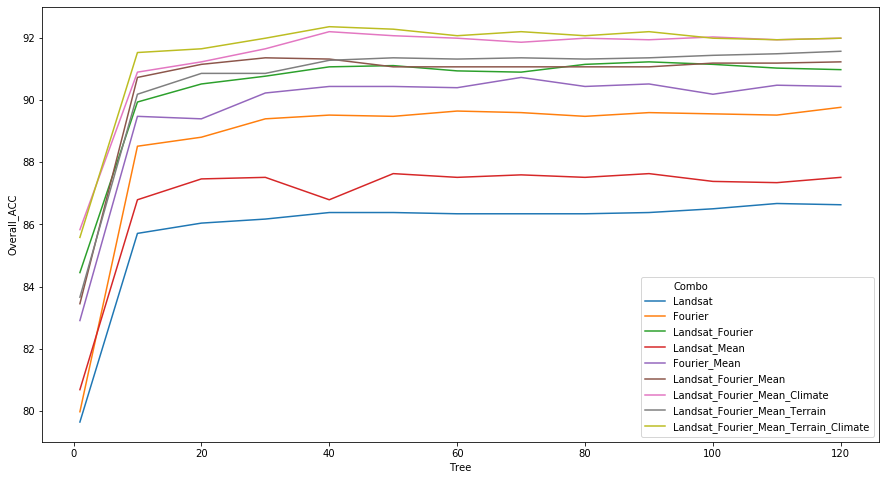

In [20]:
plt.figure(figsize=(15,8))
sns.lineplot(data = Landsat_8,x = 'Tree',y='Overall_ACC',hue='Combo')

<Figure size 720x432 with 0 Axes>

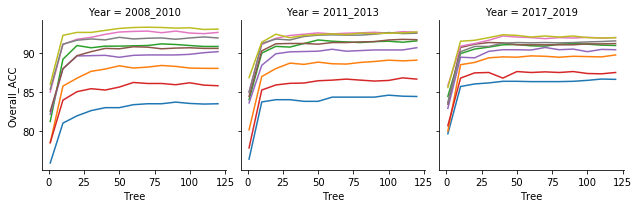

In [13]:
plt.figure(figsize=(10,6))
fig = sns.FacetGrid(data = Full_Percent,col = 'Year',hue='Combo')
fig.map(sns.lineplot,'Tree','Overall_ACC')

In [14]:
Combo_acc_df

,Year,Combo,Percent,Tree,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
0,2017_2019,Landsat,1,1,62.50,55.56,83.33,90.91,38.46
1,2017_2019,Landsat,1,10,62.50,56.25,75.00,81.82,46.15
2,2017_2019,Landsat,1,20,75.00,69.23,81.82,81.82,69.23
3,2017_2019,Landsat,1,30,70.83,66.67,75.00,72.73,69.23
4,2017_2019,Landsat,1,40,70.83,66.67,75.00,72.73,69.23
...,...,...,...,...,...,...,...,...,...
3856,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,80,93.28,92.47,94.05,93.60,92.99
3857,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,90,93.20,92.31,94.04,93.60,92.83
3858,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,100,93.24,92.31,94.12,93.69,92.83
3859,2008_2010,Landsat_Fourier_Mean_Terrain_Climate,100,110,93.03,92.13,93.88,93.43,92.67


<Figure size 288x288 with 0 Axes>

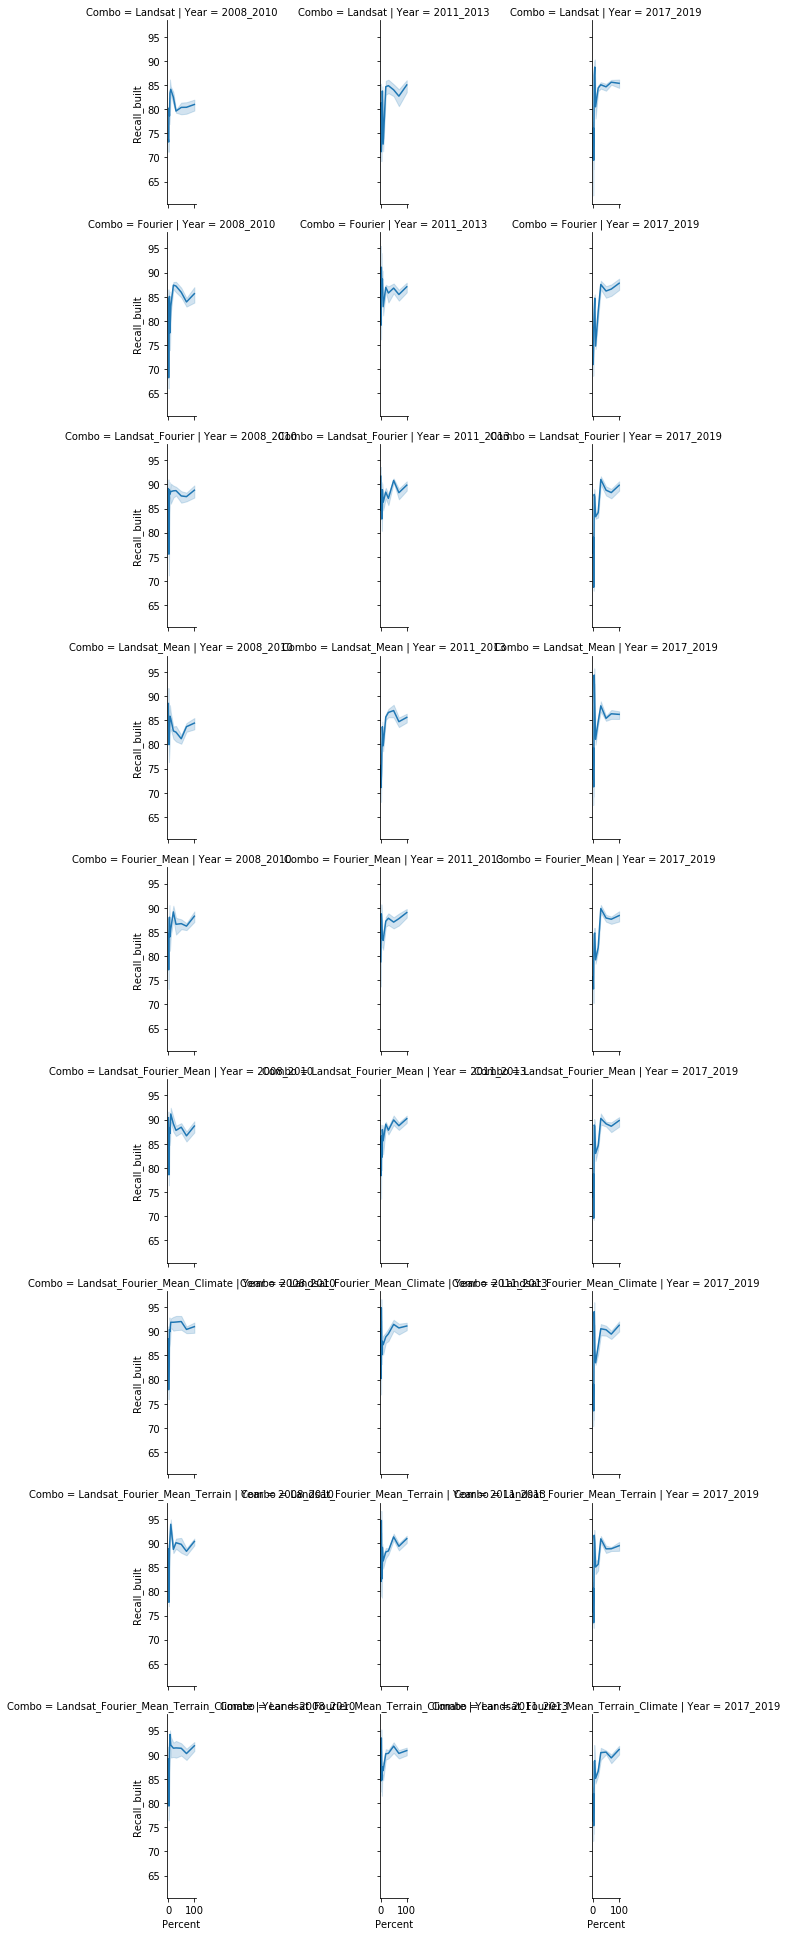

In [22]:
plt.figure(figsize=(4,4))
g = sns.FacetGrid(data = Combo_acc_df,row = 'Combo',col='Year')
g.map(sns.lineplot,'Percent','Recall_built')